In this notebook, we're going to generate some synthetic binary classification data and show how to train supervised cadre models (SCM) on it. We'll train a model with the default parameters, and then we'll show how we can use cross-validation for hyperparameter tuning to get better performance.

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../cadreModels')

from classificationBinary import binaryCadreModel
from sklearn.datasets import make_classification
from scipy.stats import zscore, zmap

from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style('darkgrid')

Generate data with the `sklearn.datasets.make_classification` function. Bind `X` and `y` into a `pd.DataFrame`.

In [4]:
X, y = make_classification(n_samples=50000, random_state=2125615, n_clusters_per_class=10, 
                           n_features=50, n_informative=25, n_repeated=15)

data = pd.DataFrame(X)
data.columns = ['f'+str(p) for p in data.columns]
data = data.assign(target=y)
features = data.columns[data.columns != 'target']

In [5]:
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f41,f42,f43,f44,f45,f46,f47,f48,f49,target
0,-0.562447,-4.496746,-4.496746,0.523007,5.937111,0.628727,0.261670,-3.003903,0.523007,2.877445,...,2.169409,4.228746,-2.491846,0.389091,-1.462236,-1.188389,0.389091,5.371964,0.523007,1
1,-0.466490,1.704545,1.704545,1.158476,-0.013365,0.751370,-2.209397,2.166053,1.158476,0.362309,...,-1.412764,0.007301,-4.074863,3.412430,-1.229256,-3.037757,3.412430,-5.643174,1.158476,1
2,0.950077,3.122326,3.122326,-0.534232,-3.825865,-1.757176,1.554950,0.632377,-0.534232,3.675752,...,-1.114574,0.188603,2.145846,3.929885,-7.317242,-4.200953,3.929885,-4.407239,-0.534232,0
3,0.896450,1.962297,1.962297,5.707130,-3.910068,1.387582,3.167782,5.575011,5.707130,-0.543254,...,1.480521,4.057712,0.410260,2.630305,7.187664,3.307076,2.630305,2.483412,5.707130,0
4,-0.032346,2.897824,2.897824,-0.938040,1.600827,1.681539,2.033267,-1.647245,-0.938040,0.065656,...,2.976090,6.443671,1.234381,1.099088,7.176274,-2.604756,1.099088,-1.910424,-0.938040,1


Since the features are continuous, we should standardize them.

In [6]:
D_tr, D_va = train_test_split(data, test_size=0.2, random_state=313616)

D_va[features] = zmap(D_va[features], D_tr[features])
D_tr[features] = zscore(D_tr[features])

/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

A `binaryCadreModel`'s initialization function takes the following arguments and default values:

* `M=2` -- number of cadres in model
* `gamma=10.` -- cadre-assignment sharpness
* `lambda_d=0.01` -- regularization strength for cadre-assignment weight parameter `d`
* `lambda_W=0.01` -- regularization strength for classification-weight parameter `W`
* `alpha_d=0.9` -- elastic net mixing weight for cadre-assignment weight parameter `d`
* `alpha_W=0.9` -- elastic net mixing with for classification-weight parameter `W`
* `Tmax=10000` -- maximum number of SGD steps to take
* `record=100` -- during training, how often goodness-of-fit metrics should be evaluated on the data
* `eta=2e-3` -- initial stepsize / learning rate
* `Nba=64` -- minibatch size
* `eps=1e-3` -- convergence tolerance
* `termination_metric='ROC_AUC'` -- training terminated if the difference between the most recent `termination_metric` value and the second most recent `termination_metric` is less than `eps`

Once you initialize a `binaryCadreModel`, you apply the `fit` method to train it. This method takes the following arguments and default values:

* `data` -- `pd.DataFrame` of training data
* `targetCol` -- string column-name of target feature in `data`
* `cadreFts=None` -- `pd.Index` of column-names used for cadre-assignment
* `predictFts=None` -- `pd.Index` of column-names used for target-prediction
* `dataVa=None` -- optional `pd.DataFrame` of validation data 
* `seed=16162` -- seed for parameter initialization and minibatch generation
* `store=False` -- whether or not copies `data` and `dataVa` should be added as attributes of the `binaryCadreModel`
* `progress=False` -- whether or not goodness-of-fit metrics should be printed during training

Other attributes of the `binaryCadreModel` include:

* `W` -- matrix of cadre-specific classification weights
* `W0` -- vector of cadre-specific classification biases
* `C` -- matrix of cadre centers
* `d` -- vector of cadre-assignments weights
* `metrics` -- a `dict` with `'training'` and `'validation'` as keys. Each item is a `pd.DataFrame` of goodness-of-fit metrics evaluated during training. Metrics include loss, accuracy, ROC AUC, and precision-recall (PR) AUC
* `time` -- list of computer-time values it took for each SGD step to be evaluated
* `proportions` -- during training, the proportion of the training data assigned to each cadre is recorded. This is a `pd.DataFrame` of those proportions, which lets you see if cadre assignments have converged to a stable distribution.

First we're going to train an SCM without really tuning the hyperparameters. Note that `Tmax` is quite large (20001). The number of SGD steps needed for training tends to vary wildly by dataset. Sometimes, only a few hundred are needed. Because of the convergence tolerance `eps`, if you specify too large a `Tmax`, the training will stop after progress slows.

In [7]:
scm = binaryCadreModel(Tmax=20001, record=50, eps=1e-4, lambda_W=1e-3, lambda_d=1e-3, M=10, gamma=1.)
scm.fit(D_tr, 'target', features, features, D_va, progress=True)

numbers being printed: SGD iteration, training loss, training accuracy, validation loss, validation accuracy, time
0
50 1.2984807 0.517075 1.297145 0.5141 0.16040802001953125
100 1.1886443 0.550775 1.1874509 0.5463 11.967761516571045
150 1.1525713 0.565475 1.151257 0.5635 22.949254035949707
200 1.1297761 0.574425 1.128429 0.5765 33.663105726242065
250 1.1135666 0.58145 1.1121567 0.5834 43.84789514541626
300 1.1009313 0.587875 1.099615 0.5928 53.823208808898926
350 1.0902662 0.593575 1.0889814 0.5989 63.28908324241638
400 1.0815023 0.598125 1.0802588 0.6023 73.21573829650879
450 1.0744634 0.602525 1.073235 0.6045 82.95269703865051
500 1.0682241 0.606975 1.0670334 0.6081 92.10580277442932
550 1.0628145 0.6104 1.0616798 0.6132 101.66183662414551
600 1.0579996 0.6147 1.0569385 0.6179 111.35325717926025
650 1.0539076 0.6175 1.0528872 0.6196 121.34262418746948
700 1.050068 0.6201 1.0491099 0.6229 131.49778866767883
750 1.0468949 0.6219 1.0459743 0.6246 140.51393866539001
800 1.0438342 0.6243

Once we've trained a model, we can plot the trajectories of the ROC AUC, PR AUC, and accuracy. These plots suggest that a little bit more training time might have been useful, as the AUCs are still increasing.

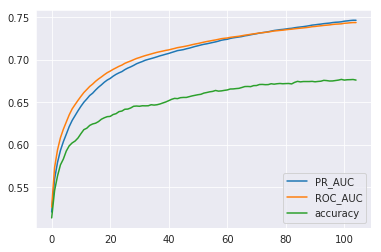

In [8]:
scm.metrics['validation'].drop('loss', axis=1).plot()

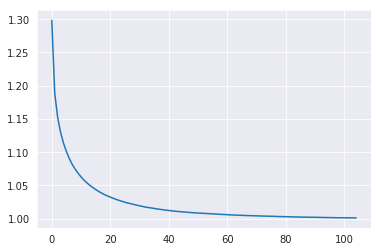

In [9]:
scm.metrics['training']['loss'].plot()

We can use the `scoreMetrics` method to calculate a variety of goodness-of-fit metrics on a new dataset.

In [10]:
scm.scoreMetrics(D_va)

,PR_AUC,ROC_AUC,accuracy,loss
0,0.746555,0.743861,0.6762,0.693101


The `entropy` method calculates the conditional entropy of the cadre-assignment random variable. This quantifies the confidence of an observation's most likely cadre-assignment.

Each cadre (value of `M`) gets its own conditional entropy. Conditional entropies close to `log2(M)` indicate lots of uncertainty in cadre-assignment for that cadre, and conditional entropies close to 0 indicate very little uncertainty.

More detail about the use of conditional entropy can be found in `arXiv:1808.04880`.

In [41]:
np.log2(10)

3.321928094887362

These conditional entropies are all fairly close to their maximum value. This means that the SCM's classification function should not be treated as being very piecewise linear -- there is a lot of nonlinearity in predicted labels. We could try to fix this by retraining with a larger `gamma` value, or we can simply accept it.

This particular dataset is fairly nonlinear, I believe, so it's not surprising that the conditional entropies are large.

In [40]:
scm.entropy(D_tr)

array([3.08914561, 3.09106624, 3.19445972, 3.09472192, 3.10619275,
       3.01084184, 3.05615803, 3.18887349, 3.10599752, 3.0484128 ])

The `predictFull` method is the one-step prediction function for a new dataset. It returns:

- `f` -- classification margins
- `l` -- predicted labels
- `G` -- cadre-membership probabilities
- `m` -- predicted cadres
- `l` -- loss function value

In [13]:
f, l, G, m, l = scm.predictFull(D_va)

In [14]:
pd.Series(m).value_counts()

5    1380
9    1259
6    1243
1    1243
4    1075
3    1012
8     921
0     801
7     584
2     482
dtype: int64

In addition to the `predictFull` method, there are more specific prediction methods:
- `predictMargin` -- returns `f`
- `predictClass` -- returns `l`
- `predictCadre` -- returns `m`

Now we're going to use 5-fold cross-validation for better hyperparameter tuning. This involves a lot of training, so we're going to do it in parallel.

In [ ]:
from itertools import product
from joblib import Parallel, delayed

In [23]:
def scmCrossval(d_tr, d_va, d_te, M, l_W, l_d, cadre_fts, predict_fts, Tmax, record):
    mod = binaryCadreModel(
                Tmax=Tmax, record=record,
                M=M, alpha_d=0.99, alpha_W=0.99, lambda_d=l_d, lambda_W=l_W, gamma=1.)
        
    mod.fit(d_tr, 'target', cadre_fts, predict_fts, d_va, progress=False)
    
    ## evaluate on validation and test sets
    err_va = mod.scoreMetrics(d_va)
    err_te = mod.scoreMetrics(d_te)
    
    ## return everything as a list
    return mod, err_va, err_te

In [24]:
from sklearn.model_selection import KFold

These are the possible hyperparameter configurations we are going to search over.

In [25]:
l_ds = np.array([0.01, 0.001])
l_Ws = np.array([0.01, 0.001])
Ms = np.array([4,6,8,10])
n_folds = 5

In [26]:
kf = KFold(n_splits=n_folds, random_state=1414)

n_jobs = np.minimum(12, n_folds * Ms.shape[0] * l_ds.shape[0] * l_Ws.shape[0])

results = (Parallel(n_jobs=n_jobs, backend='threading', verbose=11)(delayed(scmCrossval)
                    (D_tr.iloc[tr], D_tr.iloc[va], D_va, M, l_W, l_d, features, features, 20001, 1000) 
                    for (M, l_d, l_W, (fold, (tr, va))) in product(Ms, l_ds, l_Ws, enumerate(kf.split(D_tr)))))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done  15 tasks      | elaps

This function lets us organize the cross-validation accuracy of each hyperparameter configuration.

In [27]:
def extract_scores(results):
    results_va, results_te = [], []
    for model, scores_va, scores_te in results:
        results_va.append(scores_va)
        results_va[-1] = results_va[-1].assign(M=model.M, lambda_d=model.lambda_d, lambda_W=model.lambda_W)
        
        results_te.append(scores_te)
        results_te[-1] = results_te[-1].assign(M=model.M, lambda_d=model.lambda_d, lambda_W=model.lambda_W)
    results_va = pd.concat(results_va).reset_index(drop=True)
    results_te = pd.concat(results_te).reset_index(drop=True)
    print(results_va.head())
    print(results_te.head())
    return results_va, results_te

In [31]:
scores_va, scores_te = extract_scores(results)

     PR_AUC   ROC_AUC  accuracy      loss  M  lambda_d  lambda_W
0  0.604021  0.602929  0.551625  0.840378  4      0.01      0.01
1  0.613960  0.622548  0.584375  0.816942  4      0.01      0.01
2  0.642983  0.647375  0.604875  0.757063  4      0.01      0.01
3  0.618331  0.630848  0.599500  0.833157  4      0.01      0.01
4  0.674285  0.662441  0.618750  0.741088  4      0.01      0.01
     PR_AUC   ROC_AUC  accuracy      loss  M  lambda_d  lambda_W
0  0.602458  0.598755    0.5457  0.840810  4      0.01      0.01
1  0.622536  0.622885    0.5847  0.816972  4      0.01      0.01
2  0.661772  0.661841    0.6108  0.756728  4      0.01      0.01
3  0.622284  0.629413    0.5864  0.832929  4      0.01      0.01
4  0.660926  0.645047    0.6035  0.741301  4      0.01      0.01


This function decides which hyperparameter configuration has the best validation accuracy on average, as measured by `ROC_AUC`.

In [29]:
def get_best_attributes(scores):
    group = scores.groupby(['M','lambda_d','lambda_W'])
    return group.mean().reset_index().sort_values('ROC_AUC', ascending=False).head()

In [32]:
get_best_attributes(scores_va)

,M,lambda_d,lambda_W,PR_AUC,ROC_AUC,accuracy,loss
4,6,0.001,0.001,0.784182,0.785212,0.711075,0.657471
8,8,0.001,0.001,0.768799,0.773369,0.701000,0.672957
0,4,0.001,0.001,0.770133,0.772715,0.701675,0.649345
12,10,0.001,0.001,0.749394,0.752592,0.681225,0.684820
6,6,0.010,0.001,0.735939,0.735982,0.672900,0.765081


Now we'll train a final model on the entire training dataset with the best hyperparameters.

In [34]:
scm_best = binaryCadreModel(Tmax=20001, record=1000, eps=1e-4, lambda_W=0.001, lambda_d=0.001, M=6, gamma=1.)
scm_best.fit(D_tr, 'target', features, features, D_va, progress=True)

numbers being printed: SGD iteration, training loss, training accuracy, validation loss, validation accuracy, time
0
1000 1.387868 0.5104 1.3802397 0.5102 0.1609952449798584
2000 1.0543379 0.630375 1.0541757 0.6275 30.08755588531494
3000 1.0130858 0.66165 1.0136889 0.6566 60.266019105911255
4000 0.9949055 0.67395 0.9959138 0.6682 91.91009736061096
5000 0.9844632 0.68165 0.9856071 0.6769 123.66660165786743
6000 0.97760457 0.687175 0.97879696 0.6824 157.73456501960754
7000 0.9728447 0.691 0.9740023 0.6861 188.15894436836243
8000 0.9690816 0.694275 0.9702438 0.6888 219.48974514007568
9000 0.9660039 0.6967 0.967153 0.6922 250.92584085464478
10000 0.96339166 0.6987 0.96453387 0.6954 282.02784395217896
11000 0.961117 0.7006 0.9622772 0.6964 314.2528963088989
12000 0.9590633 0.7022 0.9602563 0.698 346.16024470329285
13000 0.9573027 0.703075 0.9585674 0.7004 378.1253855228424
14000 0.95571285 0.7046 0.9570452 0.7019 411.07925605773926
15000 0.95418906 0.706775 0.9556563 0.7035 442.977862834930

This is the accuracy of the original untuned model.

In [36]:
scm.scoreMetrics(D_va)

,PR_AUC,ROC_AUC,accuracy,loss
0,0.746555,0.743861,0.6762,0.693101


This is the accuracy of the tuned model.

In [35]:
scm_best.scoreMetrics(D_va)

,PR_AUC,ROC_AUC,accuracy,loss
0,0.788421,0.787379,0.7102,0.657289


We see that, by utilizing proper hyperparameter tuning, we are able to increase our `PR_AUC` and `ROC_AUC` scores by about 5% and our accuracy by about 4%.

This function can be used to calculate subpopulation-specific metrics. It can be useful to notice if one subpopulation has particularly good or bad accuracy relative to the population.

In [46]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [47]:
def precision_metrics(data, model, data_name, M):
    F, L, __, M, __ = model.predictFull(data)
    temp = pd.DataFrame({'f': np.squeeze(F), 'm': np.squeeze(M), 'l': np.squeeze(L), 'y': data['target'].values})
    scores = {'size': [], 'm': [], 'dataset': [], 'accuracy': [], 'ROC_AUC': [], 'PR_AUC': [], 'proportion': []}
    for m in np.unique(M):
        temp_m = temp.loc[temp['m']==m,:]
        if temp_m.shape[0] < 5: continue
        scores['size'].append(temp_m.shape[0])
        scores['m'].append(m)
        scores['dataset'].append(data_name)
        scores['proportion'].append(temp_m['y'].mean())
        scores['accuracy'].append(np.mean(temp_m['l'] == temp_m['y']))
        scores['ROC_AUC'].append(roc_auc_score(temp_m['y'], temp_m['f']))
        scores['PR_AUC'].append(average_precision_score(temp_m['y'], temp_m['f']))
    return pd.DataFrame(scores)[['dataset', 'm', 'size', 'proportion', 'accuracy', 'ROC_AUC', 'PR_AUC']]

In [48]:
precision_metrics(D_va, scm_best, 'synthetic', 6)

,dataset,m,size,proportion,accuracy,ROC_AUC,PR_AUC
0,synthetic,0,1404,0.505698,0.724359,0.793205,0.796738
1,synthetic,1,1666,0.597239,0.717287,0.779810,0.837128
2,synthetic,2,2516,0.411367,0.717011,0.791501,0.717528
3,synthetic,3,1414,0.389675,0.673267,0.731547,0.615325
4,synthetic,4,1492,0.615282,0.715818,0.789958,0.857002
5,synthetic,5,1508,0.548408,0.706897,0.780402,0.806799


In this case, we see that cadre 4 has the best `PR_AUC`, and cadre 0 has the best `ROC_AUC`. Cadre 3 has the worst `ROC_AUC` and `PR_AUC`.